# Self-Organizing Map

In [2]:
import sys
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import psycopg2.extras

root_path = Path().resolve().parent.parent
sys.path.append(str(root_path))

from src.dataset.connection import connect_to_spotify_dataset
from src.dataset.connection import select

In [3]:
connection = connect_to_spotify_dataset() # Add db Password
if not connection:
    print("Connection Error")
tds = select(connection, "SELECT * FROM track_data") 

Connection successful
Connection closed.


In [4]:
columns = [
    "id", "name", "popularity", "duration_ms", "explicit", "artists", "id_artists", "release_date",
    "danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", 
    "instrumentalness", "liveness", "valence", "tempo", "time_signature","decade", "mood_index", "emotion_index", "party_index", "chill_index"
]
# Create the DataFrame
df = pd.DataFrame(tds, columns=columns)
df.head()

id                   object
name                 object
popularity            int64
duration_ms           int64
explicit               bool
artists              object
id_artists           object
release_date         object
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                   bool
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
decade                int64
mood_index          float64
emotion_index       float64
party_index         float64
chill_index         float64
dtype: object


,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,instrumentalness,liveness,valence,tempo,time_signature,decade,mood_index,emotion_index,party_index,chill_index
0,1mC0LEmjbCXjs8jjnYIjHw,Yo También Era Dichoso - Instrumental (Remaste...,0,170933,False,[Francisco Canaro],[2maQMqxNnlRrBrS1oAsrX9],1927-09-11,0.808,0.398,...,0.328,0.173,0.6680,114.891,4,1920,0.65600,4.37150,0.6030,0.8024
1,21010f0ucoaLEEn4khQKZb,T for Texas,1,208000,False,[Jimmie Rodgers],[0Y0ZlznP6vzTS1qAm5dvTN],1927,0.571,0.718,...,0.000,0.309,0.5650,78.849,4,1920,0.59740,1.61200,0.6445,0.6774
2,2fPzoKtGjXFDgzIOSAfrEq,Chapter 1 & Chapter 2.1 - Sprawy Sherlocka Hol...,0,128038,False,[Arthur Conan Doyle],[2AcBhTO6Q3zzUrfPKmskp3],1927-07-29,0.703,0.321,...,0.000,0.310,0.8030,87.746,3,1920,0.67660,5.69210,0.5120,0.7738
3,3B6gBlf64fMQY3sbkyFENu,Purple Daze,0,192332,False,[Cellular Project],[6OOyYaxY66YrMwusS1PIr6],1927,0.344,0.857,...,0.874,0.125,0.1580,140.669,4,1920,0.35360,1.95260,0.6005,0.2312
4,3KD6IGlsy0OmvQ5EZVSGwf,Iris: Inno al sole,0,231987,False,"[Pietro Mascagni, Staatskapelle Berlin]","[3Z5fRknMBBNfCw6pkgR9S8, 7vEPPI71V8dEHtEhPMAxWT]",1927-04-01,0.188,0.139,...,0.902,0.817,0.0387,74.178,3,1920,0.10355,5.63778,0.1635,0.9312


# Feature Engineering

In [24]:
#chill index:
#measures how calm and acoustic a song is
df[["name","artists","chill_index"]]

,name,artists,chill_index
0,Yo También Era Dichoso - Instrumental (Remaste...,[Francisco Canaro],0.8024
1,T for Texas,[Jimmie Rodgers],0.6774
2,Chapter 1 & Chapter 2.1 - Sprawy Sherlocka Hol...,[Arthur Conan Doyle],0.7738
3,Purple Daze,[Cellular Project],0.2312
4,Iris: Inno al sole,"[Pietro Mascagni, Staatskapelle Berlin]",0.9312
...,...,...,...
525582,Kapitel 199 - Der Page und die Herzogin,"[Georgette Heyer, Irina Salkow]",0.5632
525583,Kapitel 186 - Der Page und die Herzogin,"[Georgette Heyer, Irina Salkow]",0.6432
525584,Corrientes - Remasterizado,[Francisco Canaro],0.8756
525585,Kapitel 180 - Der Page und die Herzogin,"[Georgette Heyer, Irina Salkow]",0.5930


In [40]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

selected_columns = ['popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key',
                    'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
                    'liveness', 'valence', 'tempo', 'decade',"mood_index","emotion_index","party_index","chill_index"]

X = df[selected_columns]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

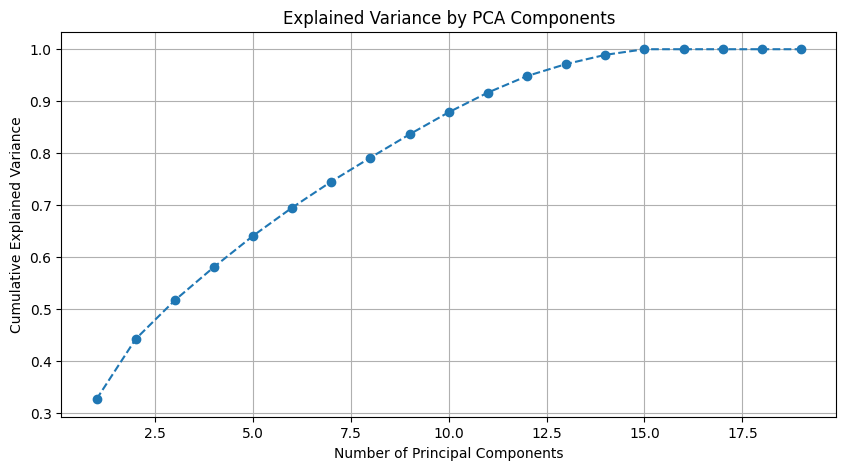

In [41]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(selected_columns) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid()
plt.show()

In [42]:
explained_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(explained_variance >= 0.95) + 1  # Get number of components for 95% variance

print(f"Number of components needed to explain 95% variance: {n_components}")

pca_final = PCA(n_components=n_components)
X_pca_final = pca_final.fit_transform(X_scaled)

df_pca = pd.DataFrame(X_pca_final, columns=[f'PC{i+1}' for i in range(n_components)])

Number of components needed to explain 95% variance: 13


In [43]:
df_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
0,1.823652,-2.941102,-0.968966,-0.584327,0.986108,-0.179790,0.398474,-1.628679,-0.567399,0.221997,-0.208314,-0.329435,0.368153
1,0.367736,-1.409699,-1.670282,1.295385,-0.885038,-1.348382,2.141578,-1.573808,0.875939,0.575058,-0.614133,-0.320171,-0.320742
2,2.554092,-4.657463,1.888453,1.599435,1.795461,0.033669,0.203990,-0.254068,-0.914265,0.180363,-1.912765,-0.920434,-1.214302
3,0.615676,1.263781,-2.939935,1.337242,0.324782,1.066355,-0.353780,-2.166430,1.655458,-1.146505,-1.455600,-1.356830,-0.539754
4,6.623513,0.935577,-0.835520,3.111189,0.664170,1.409538,1.173034,-1.349267,1.284934,-0.233185,1.414903,0.364529,-0.095561
...,...,...,...,...,...,...,...,...,...,...,...,...,...
525582,3.521582,-3.093360,2.906361,2.025112,1.224332,0.747963,0.777937,1.315022,1.042243,-0.708736,-3.113539,-0.595150,-0.184440
525583,3.872591,-3.247692,2.605968,1.451096,1.233073,0.571663,0.066358,1.492890,0.958335,-0.422988,-3.172839,-0.751336,-0.442836
525584,2.359059,-2.241527,-2.090643,-0.408973,0.741425,0.306163,0.248950,-3.003056,-0.280930,-0.264948,0.794708,-1.126944,-0.347654
525585,3.949948,-2.786295,2.877097,1.620917,2.328034,0.529651,-0.056581,0.516022,-0.629066,-0.690489,-3.067532,-0.343536,-0.404658


### Model Training

In [2]:
from minisom import MiniSom
from sklearn.metrics import davies_bouldin_score


Matplotlib is building the font cache; this may take a moment.


In [ ]:
# MiniSom Clustering Model
grid_x, grid_y = 10, 10

# Initialize SOM
som = MiniSom(grid_x, grid_y, 13, sigma=1.0, learning_rate=0.5)
som.random_weights_init(X_pca_final)

# Train SOM
som.train_random(data, num_iterations = 10000)

In [ ]:
# Assign each data point to its Best Matching Unit (BMU)
bmu_indices = np.array([som.winner(x) for x in X_pca_final])

# Convert BMU indices to cluster labels
cluster_labels = np.array([x * grid_y + y for x, y in bmu_indices])

# Compute Sum of squared Euclidean distances to BMUs
bmu_weights = np.array([som.get_weights()[x, y] for x, y in bmu_indices])
inertia = np.sum(np.linalg.norm(data - bmu_weights, axis=1) ** 2)

# Compute Davies-Bouldin Index
db_index = davies_bouldin_score(data, cluster_labels)

print(f"Inertia: {inertia:.4f}")
print(f"Davies-Bouldin Index: {db_index:.4f}")

# Plot SOM Clusters
plt.figure(figsize=(10, 10))
for i, x in enumerate(data):
    winner = som.winner(x)
    plt.scatter(winner[0], winner[1], marker='o', color='blue', alpha = 0.5)

plt.title("Self-Organizing Map (SOM) Clustering")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid()
plt.show()

In [ ]:
#import susi

In [3]:
# Susi SoM Clustering Model

In [ ]:
#som2 = susi.SOMClustering(n_rows = 10, n_columns = 10, n_iter_unsupervised=1000,learning_rate_start = 0.5, learning_rate_end = 0.05, random_state = 999)

#som2.fit_transform(X_pca_final)
#bmu_list = som2.get_bmus(X_pca_final)
#plt.hist2d([x[0] for x in bmu_list], [x[1] for x in bmu_list]